In [1]:
import shap
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport
from deepchecks.tabular import Dataset
from deepchecks.tabular.checks import FeatureDrift

from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from catboost import (
    CatBoostRegressor,
    CatBoostClassifier,
    Pool, 
    cv, 
    EShapCalcType, 
    EFeaturesSelectionAlgorithm
)


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 200)

# Функции

### Функция для расчета метрики

In [2]:
def weighted_mean_absolute_error(y_true, y_pred, weights):

    '''

    Weighted mean absolute error.

    Parameters
    ----------
    y_true: ndarray
        Ground truth
    y_pred: ndarray
        Array of predictions

    Returns
    -------
    rmsle: float
        Weighted mean absolute error

    References
    ----------
    .. [1] https://kaggle-metrics.readthedocs.io/en/latest/_modules/kaggle_metrics/regression.html

    '''
    
    return (weights * np.abs(y_true - y_pred)).mean()

### Функция для обучения базовой модели

In [3]:
def fit_catboost(features_train, 
                 features_val, 
                 target_train, 
                 target_val, 
                 cat_features, 
                 n_iter=500,
                 train_weight=None,
                 val_weight=None):
    
    pool_train = Pool(
        features_train,
        target_train,
        weight = train_weight,
        cat_features = cat_features
    )

    pool_val = Pool(
        features_val,
        target_val,
        weight = val_weight,
        cat_features = cat_features
    )

    model = CatBoostRegressor(
        iterations= n_iter,
        learning_rate=0.05,
        loss_function='RMSE',
        random_seed = 42
    )

    model.fit(
        pool_train,
        eval_set=pool_val,
        verbose=100,
        plot=True
    )

    return model

# Чтение данных

In [4]:
train_df = pd.read_csv('data/train.csv', sep=";", decimal=",", encoding="windows-1251")
test_df = pd.read_csv('data/test.csv', sep=";", decimal=",", encoding="windows-1251")

features_description = (
    pd.read_excel('data/description.xlsx', index_col='field')
    .to_dict()['description']
)

train_df.shape, test_df.shape

((205962, 235), (37183, 233))

# Предварительный анализ EDA

In [5]:
features = list(train_df.drop(['client_id', 'feature_date', 'target', 'w'], axis=1).columns)
train_df[features].select_dtypes('object').head()

,addrref,bki_total_ip_max_limit,hdb_bki_active_cc_cnt,hdb_bki_active_ip_max_outstand,hdb_bki_active_micro_max_outstand,hdb_bki_active_pil_max_overdue,hdb_bki_other_active_auto_month_payments_sum,hdb_bki_total_cc_max_limit,hdb_bki_total_ip_cnt,hdb_bki_total_max_limit,hdb_bki_total_max_overdue_sum,hdb_bki_total_pil_max_limit,main_last_position_ccode,main_pre_last_position_ccode,oldest_campaignsegment_ccode_for_nss,oldest_campaignsegment_ccode_for_pil,part_last_position_ccode,part_pre_last_position_ccode,segment,brand,model
0,Свердловская область,NaN,2.0,1006774.6,NaN,0.0,NaN,170000.0,1.0,4250000.0,235937.0,220000.0,NaN,NaN,NaN,PIL2CC,NaN,NaN,Mass Affluent,NaN,NaN
1,Новосибирская область,NaN,6.0,NaN,NaN,0.0,NaN,110000.0,0.0,183500.0,2527.0,183500.0,NaN,NaN,ACFYN_NZP,PIL2PIL,NaN,NaN,Mass Affluent,NaN,NaN
2,Новосибирская область,NaN,4.0,NaN,NaN,0.0,NaN,65000.0,0.0,558500.0,7678.0,558500.0,NaN,NaN,ACFYN_NZP,PIL2PIL,NaN,NaN,Mass Affluent,NaN,NaN
3,Московская область,NaN,0.0,646694.0,NaN,NaN,NaN,0.0,3.0,1780000.0,0.0,427000.0,NaN,NaN,ACFYN_NZP,PIL2PAY,NaN,NaN,Mass Affluent,NaN,NaN
4,Краснодарский край,NaN,3.0,NaN,NaN,14264.13,NaN,62500.0,0.0,1120000.0,14264.13,1120000.0,NaN,NaN,ACFYN_NZP,PIL2PAY,NaN,NaN,Mass,NaN,NaN


### Поправляем типы данных для фичей

In [6]:
print('Количество униклаьных значений по фиче:')
for f in train_df[features].select_dtypes('object').columns:
    print(f"{f}: {train_df[f].value_counts().count()}")

Количество униклаьных значений по фиче:
addrref: 59
bki_total_ip_max_limit: 2763
hdb_bki_active_cc_cnt: 60
hdb_bki_active_ip_max_outstand: 43267
hdb_bki_active_micro_max_outstand: 5458
hdb_bki_active_pil_max_overdue: 24365
hdb_bki_other_active_auto_month_payments_sum: 3533
hdb_bki_total_cc_max_limit: 9991
hdb_bki_total_ip_cnt: 15
hdb_bki_total_max_limit: 52263
hdb_bki_total_max_overdue_sum: 56162
hdb_bki_total_pil_max_limit: 54202
main_last_position_ccode: 9207
main_pre_last_position_ccode: 5192
oldest_campaignsegment_ccode_for_nss: 56
oldest_campaignsegment_ccode_for_pil: 13
part_last_position_ccode: 1236
part_pre_last_position_ccode: 1325
segment: 3
brand: 422
model: 2397


В соответствии с описанием фичей было выяснено, что для всех фичей, которые начинаются с 'hdb_bki' требуется выставить тип данных float

In [7]:
newtype_feats = [
    'bki_total_ip_max_limit',
    'hdb_bki_active_cc_cnt',
    'hdb_bki_active_ip_max_outstand',
    'hdb_bki_active_micro_max_outstand',
    'hdb_bki_active_pil_max_overdue',
    'hdb_bki_other_active_auto_month_payments_sum',
    'hdb_bki_total_cc_max_limit',
    'hdb_bki_total_ip_cnt',
    'hdb_bki_total_max_limit',
    'hdb_bki_total_max_overdue_sum',
    'hdb_bki_total_pil_max_limit'
]

test_df[newtype_feats] = test_df[newtype_feats].astype('float64')
test_df['feature_date'] = test_df['feature_date'].astype('datetime64[ns]')

train_df[newtype_feats] = train_df[newtype_feats].astype('float64')
train_df['feature_date'] = train_df['feature_date'].astype('datetime64[ns]')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205962 entries, 0 to 205961
Columns: 235 entries, client_id to productionyear
dtypes: datetime64[ns](1), float64(223), int64(1), object(10)
memory usage: 369.3+ MB


In [8]:
cat_features = list(train_df[features].select_dtypes('object').columns)
num_features = list(set(features) - set(cat_features))

len(features), len(cat_features), len(num_features)

(231, 10, 221)

### Анализ категорильных фичей

In [9]:
# сколько всего записей, где известна должность, но не известна зп?
train_df.loc[
    (train_df['worksalary_rur_amt'].isna())
    & (~train_df['part_last_position_ccode'].isna())
].shape

(4184, 235)

In [10]:
# df, содержащий медианные зарплаты для должностей по всем данным
median_worksalary = (
    pd.concat([train_df[features], test_df[features]], axis=0)
    .dropna(subset = 'worksalary_rur_amt')
    .groupby('part_last_position_ccode', as_index=False)
    ['worksalary_rur_amt'].median()
    .rename(columns={'worksalary_rur_amt': 'median_worksalary_rur_amt'})
)
median_worksalary.head()

,part_last_position_ccode,median_worksalary_rur_amt
0,АВТОМЕХАНИК,158892.5
1,АДМИНИСТРАТОР,180000.0
2,АНАЛИТИК,100000.0
3,Администратор,60000.0
4,Администратор магазина,70000.0


In [11]:
test_df = test_df.merge(median_worksalary, on='part_last_position_ccode', how='left')
test_df['worksalary_rur_amt'] = test_df['worksalary_rur_amt'].fillna(test_df['median_worksalary_rur_amt'])
test_df.drop('median_worksalary_rur_amt', axis=1, inplace=True)

train_df = train_df.merge(median_worksalary, on='part_last_position_ccode', how='left')
train_df['worksalary_rur_amt'] = train_df['worksalary_rur_amt'].fillna(train_df['median_worksalary_rur_amt'])
train_df.drop('median_worksalary_rur_amt', axis=1, inplace=True)

train_df.loc[
    (train_df['worksalary_rur_amt'].isna())
    & (~train_df['part_last_position_ccode'].isna())
].shape

(1029, 235)

In [12]:
# заполняем пропуски в категориальных
train_df[cat_features] = train_df[cat_features].fillna('miss_value')
test_df[cat_features] = test_df[cat_features].fillna('miss_value')

# Инженерия фич

In [13]:
train_df['feature_date_year'] = train_df['feature_date'].dt.year
train_df['feature_date_month'] = train_df['feature_date'].dt.month
train_df['feature_date_day'] = train_df['feature_date'].dt.day

test_df['feature_date_year'] = test_df['feature_date'].dt.year
test_df['feature_date_month'] = test_df['feature_date'].dt.month
test_df['feature_date_day'] = test_df['feature_date'].dt.day

### Получаем предсказания модели, которая предсказывает сегмент доходности клиента (model_clf)

In [22]:
clf_model = CatBoostClassifier()
clf_model.load_model('models/3cl_6_9_model_clf')

with open('models/3cl_6_9_label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

train_df['target_bins'] = None
train_df.loc[train_df['target'] <= train_df['target'].quantile(0.333), 'target_bins'] = 'bin_0'
train_df.loc[
    (train_df['target'] > train_df['target'].quantile(0.333))
    & (train_df['target'] <= train_df['target'].quantile(0.666)), 
    'target_bins'
] = 'bin_1'
train_df.loc[train_df['target'] > train_df['target'].quantile(0.666), 'target_bins'] = 'bin_2'

train_df['target_bins'] = le.transform(train_df['target_bins'])

# train_df['target_bins'] = clf_model.predict(train_df[clf_model.feature_names_])[:,-1]
# train_df['cl0_prob'] = clf_model.predict_proba(train_df[clf_model.feature_names_])[:,0]
# train_df['cl1_prob'] = clf_model.predict_proba(train_df[clf_model.feature_names_])[:,1]
# train_df['cl2_prob'] = clf_model.predict_proba(train_df[clf_model.feature_names_])[:,2]

test_df['target_bins'] = clf_model.predict(test_df[clf_model.feature_names_])[:,-1]
# test_df['cl0_prob'] = clf_model.predict_proba(test_df[clf_model.feature_names_])[:,0]
# test_df['cl1_prob'] = clf_model.predict_proba(test_df[clf_model.feature_names_])[:,1]
# test_df['cl2_prob'] = clf_model.predict_proba(test_df[clf_model.feature_names_])[:,2]
test_df.head()

,client_id,feature_date,accum_rur_amt_cm_avg_div_v2,addrref,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__bilety_na_kontserty_i_v_teatry,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__brokerskie_uslugi,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__hosting,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__spa_sauny_bani,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__tovary_dlja_detej,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__turisticheskie_agenstva,amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__marketplejsy,amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__nalogi,amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__ohota_i_rybalka,amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__prochie_bilety,atravel,avg_3m_hotels,avg_6m_building_services,avg_6m_money_transactions,avg_6m_personal_services,avg_6m_transportation,avg_by_category__amount__sum__cashflowcategory_name__detskie_igrushki,avg_by_category__amount__sum__cashflowcategory_name__investitsii,avg_by_category__amount__sum__cashflowcategory_name__odezhda_dlja_beremennyh,avg_by_category__amount__sum__cashflowcategory_name__vydacha_nalichnyh_v_bankomate,avg_by_category__amount__sum__cashflowcategory_name__zdorove,avg_by_category__amount__sum__cashflowcategory_name__zooparki,avg_cnt_daily_transactions_90d,avg_debet_turn_rur,avg_percents_inc,bki_total_ip_max_limit,by_category__amount__sum__eoperation_type_name__perevod_mezhdu_svoimi_schetami,by_category__amount__sum__eoperation_type_name__platezh_cherez_vidzhet_moj_mobilnyj,by_category__amount__sum__eoperation_type_name__pokupka_paja,by_category__amount__sum__eoperation_type_name__vneshnij_perevod_rur,calls_weight_v2,card_dda_rur_amt_cm_avg_div_v2,cc_other_rate_max_2avg_prop,channel_agentskij_kanal_voc_features_12m_avg_mark,channel_agentskij_kanal_voc_features_12m_cnt_mark,channel_bankomaty_voc_features_36m_avg_mark,channel_bankomaty_voc_features_36m_voc_without_marks_portion,channel_bankomaty_voc_features_3m_mark_eq_5_flag,channel_bankomaty_voc_features_full_mark_eq_5_flag,channel_bankomaty_voc_features_full_voc_not_null_flag,channel_chat_s_operatorom_alfainvestitsii_voc_features_12m_avg_mark,channel_chat_s_operatorom_alfainvestitsii_voc_features_36m_mark_not_null_flag,channel_chat_s_operatorom_voc_features_12m_cnt_mark,channel_chat_s_operatorom_voc_features_12m_mark_eq_3_flag,channel_chat_s_operatorom_voc_features_12m_voc_with_expert_cnt,channel_chat_s_operatorom_voc_features_3m_mark_eq_4_flag,channel_chat_s_operatorom_voc_features_full_voc_without_marks_portion,channel_chatbot_alfainvestitsii_voc_features_12m_mark_in_4_5_flag,channel_chatbot_alfainvestitsii_voc_features_12m_voc_with_expert_portion,channel_chatbot_alfainvestitsii_voc_features_36m_mark_eq_3_flag,channel_chatbot_alfainvestitsii_voc_features_36m_min_mark,channel_chatbot_alfainvestitsii_voc_features_3m_mark_eq_5_flag,channel_chatbot_alfainvestitsii_voc_features_3m_mark_in_4_5_flag,channel_chatbot_alfainvestitsii_voc_features_full_avg_mark,channel_chatbot_voc_features_12m_mark_in_1_3_flag,channel_chatbot_voc_features_12m_voc_with_expert_portion,channel_chatbot_voc_features_full_voc_without_marks_portion,channel_collection_voc_features_36m_cnt_mark,channel_collection_voc_features_36m_mark_eq_2_flag,channel_collection_voc_features_36m_voc_not_null_flag,channel_collection_voc_features_3m_voc_with_expert_portion,channel_collection_voc_features_full_voc_without_marks_portion,channel_finansovyj_sovetnik_voc_features_36m_avg_mark,channel_finansovyj_sovetnik_voc_features_3m_voc_with_expert_portion,channel_finansovyj_sovetnik_voc_features_full_avg_mark,channel_finansovyj_sovetnik_voc_features_full_voc_with_expert_cnt,channel_frodmonitoring_voc_features_12m_mark_eq_2_flag,channel_frodmonitoring_voc_features_12m_max_mark,channel_frodmonitoring_voc_features_3m_mark_in_4_5_flag,channel_frodmonitoring_v

In [23]:
features = list(train_df.drop(['client_id', 'feature_date', 'target', 'w', 'target_bins'], axis=1).columns)

cat_features = list(train_df[features].select_dtypes('object').columns)
num_features = list(set(features) - set(cat_features))

len(features), len(cat_features), len(num_features)

(234, 10, 224)

# Обучение модели

In [24]:
features_train, features_val, target_train, target_val = train_test_split(
    train_df[features],
    train_df['target'],
    test_size=0.3,
    random_state=42
)

w_train, w_val, bins_train, bins_val = train_test_split(
    train_df['w'],
    train_df['target_bins'],
    test_size=0.3,
    random_state=42
)

## Обучение модели на всех фичах с фичами от классификатора

In [25]:
model = fit_catboost(
    features_train,
    features_val,
    target_train, 
    target_val, 
    cat_features, 
    400
)

WMAE = weighted_mean_absolute_error(target_val, model.predict(features_val), w_val)
print(f"WMAE = {WMAE:.2f}")
print(f"Overfit: {model.evals_result_['validation']['RMSE'][-1] - model.evals_result_['learn']['RMSE'][-1]}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 86722.6308951	test: 86912.3300717	best: 86912.3300717 (0)	total: 286ms	remaining: 1m 54s
100:	learn: 61242.8780421	test: 61709.5908836	best: 61709.5908836 (100)	total: 15.2s	remaining: 45s
200:	learn: 59115.7138071	test: 60096.3026703	best: 60096.3026703 (200)	total: 29.7s	remaining: 29.4s
300:	learn: 57726.3478420	test: 59275.5505979	best: 59275.5505979 (300)	total: 44.7s	remaining: 14.7s
399:	learn: 56677.4814554	test: 58826.0811459	best: 58826.0811459 (399)	total: 59.7s	remaining: 0us

bestTest = 58826.08115
bestIteration = 399

WMAE = 31898.49
Overfit: 2148.5996905507855


Text(0.5, 1.0, 'Residual Plot')

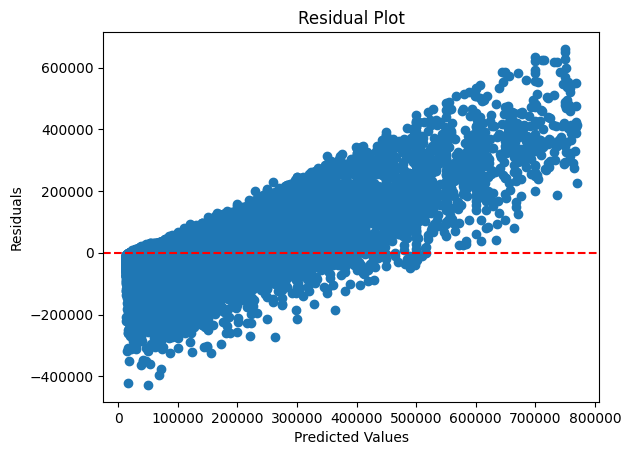

In [26]:
# Plot Residuals
residuals = target_val - model.predict(features_val)
plt.scatter(target_val, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\shap\plots\_beeswarm.py:960: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



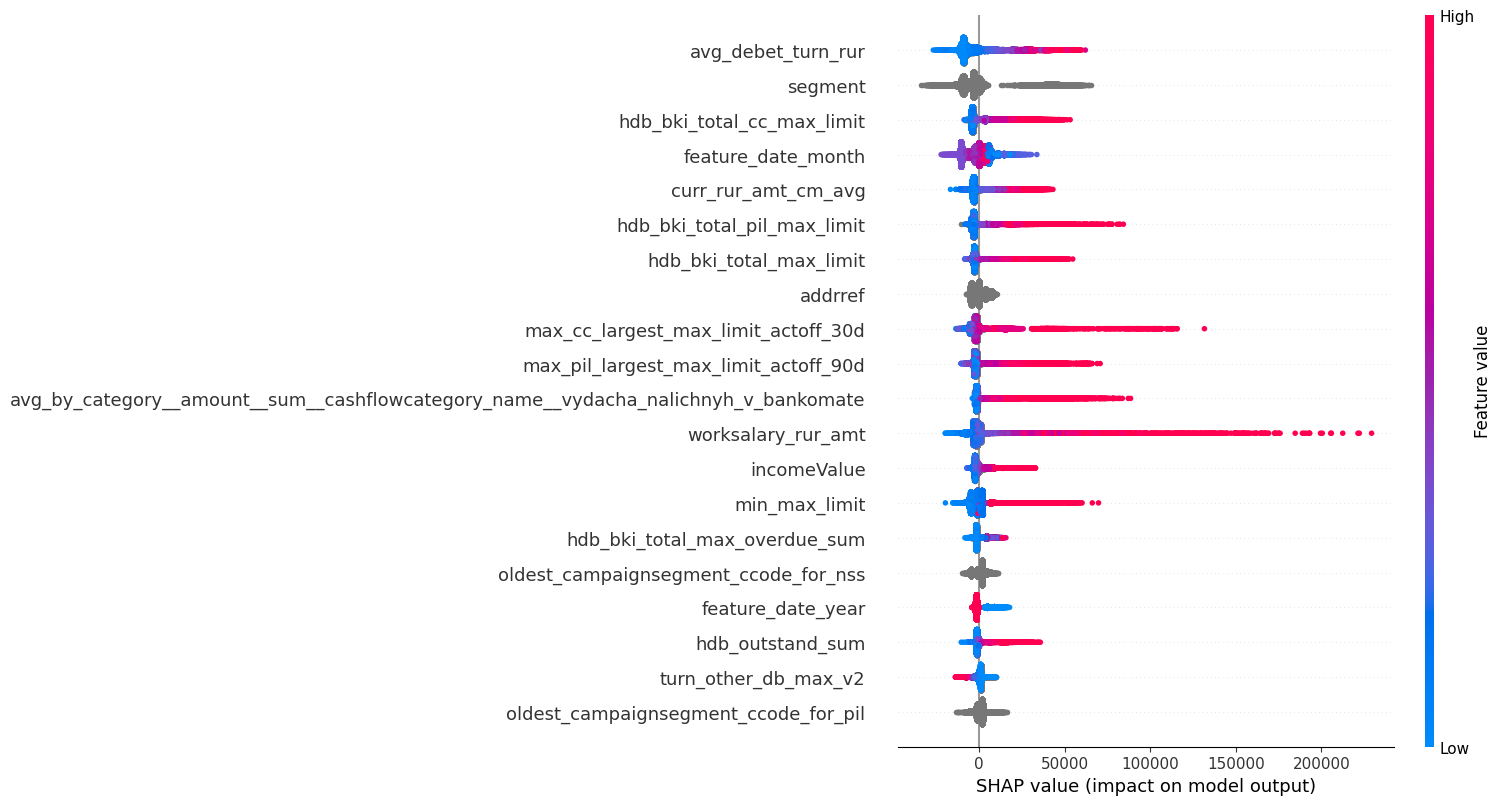

In [27]:
shap_values = (
    shap
    .TreeExplainer(model)
    .shap_values(features_val)
)
shap.summary_plot(shap_values, features_val)

In [28]:
shap_importance = (
    pd.DataFrame(
        {"feature":  features_train.columns, "importance": np.mean(np.abs(shap_values), axis=0)}
    ).sort_values("importance", ascending=False, ignore_index=True)
)
shap_importance.head()

,feature,importance
0,avg_debet_turn_rur,10111.974925
1,segment,9074.746053
2,hdb_bki_total_cc_max_limit,5493.343297
3,feature_date_month,5215.822156
4,curr_rur_amt_cm_avg,5130.274346


## Отбор фич (факторный анализ)

In [29]:
# по пропущенным значениям

def feats_filter_nan(df: pd.DataFrame,
                     num_feat: list,
                     cat_feat: list,
                     nan_threshold: float):

    """Функция отбора фичей по доле NaN-значений.
    Фичи, которые имеют долю NaN-значений не ниже заданного nan_threshold, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    num_feat : list
        список числовых фичей
    cat_feat : list
        список категориальных фичей (в нашем случае для них NaN-значением является 'miss_value')
    nan_threshold : float
        порог удаления фичи

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    # для числовых фичей
    nan_stats_num = (
        df[num_feat]
        .isna().mean(axis=0)
        .reset_index()
        .rename(columns={0: 'nan_frac', 'index': 'col'})
    )
    # для категориальных
    nan_stats_cat = (
        (df[cat_feat] == 'miss_value')
        .mean(axis=0)
        .reset_index()
        .rename(columns={0: 'nan_frac', 'index': 'col'})
    )

    nan_stats = pd.concat([nan_stats_num, nan_stats_cat])
    selected_features = list(nan_stats[nan_stats['nan_frac'] < nan_threshold]['col'])

    return selected_features


deleted_features = list(set(features) - set(feats_filter_nan(train_df, num_features, cat_features, 0.95)))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = feats_filter_nan(train_df, num_features, cat_features, 0.95)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

,feature,importance
44,first_salary_income,348.561684
49,hdb_bki_other_active_auto_month_payments_sum,316.440625
57,product_depozity_voc_features_full_voc_without...,233.349275
61,brand,193.972550
76,avg_by_category__amount__sum__cashflowcategory...,63.993651
86,unique_countries1,33.707667
98,min_cc_max_pilot_score_actoff_180d,13.196693
101,channel_pretenzii_voc_features_full_avg_mark,12.769329
106,transaction_category_hotels_sum_amt_d15,6.225631
110,transaction_category_airplane_tickets_sum_cnt_d15,3.268402


146

Отброшены потенцильно хорошие фичи. Вернем их в список фичей

In [30]:
selected_features += list(
    shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[:4]
)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

150

In [31]:
# по доле самого частого значения

def feats_filter_nunique(df: pd.DataFrame,
                         features: list,
                         unique_threshold: float):

    """Функция отбора фичей по доле самого частого значения.
    Фичи, которые имеют 1 уникальное значение (помимо NaN), либо для которых
      доля самого частого значения (включая NaN) не ниже unique_threshold, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    features : list
        список фичей
    unique_threshold : float
        порог удаления фичи

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    selected_features = []

    for feat in features:
        if df[feat].nunique() >= 2 and df[feat].astype(str).value_counts(1).values[0] < unique_threshold:
            selected_features += [feat]

    return selected_features

deleted_features = list(set(selected_features) - set(feats_filter_nunique(train_df, selected_features, 0.95)))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = feats_filter_nunique(train_df, selected_features, 0.95)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

,feature,importance
44,first_salary_income,348.561684
49,hdb_bki_other_active_auto_month_payments_sum,316.440625
57,product_depozity_voc_features_full_voc_without...,233.349275
61,brand,193.972550
88,channel_bankomaty_voc_features_full_voc_not_nu...,29.555108
202,loan_on_realty_clicks_90,0.000000
221,channel_otdelenija_voc_features_full_voc_not_n...,0.000000


143

In [32]:
selected_features += list(
    shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[:4]
)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

147

In [33]:
# отсечение по рандомной фиче

def feats_filter_random_feat(df: pd.DataFrame,
                             features: list,
                             cat_features: list):

    """Функция отбора фичей при помощи отсечения менее важных фичей чем рандомная фича.
    Фичи, которые имеют в простой модели важность ниже рандомной фичи, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    features : list
        список фичей
    cat_features : list
        список категориальных фичей

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    df['random'] = np.random.uniform(0, 1, df.shape[0])

    pool_train = Pool(
        df[features + ['random']],
        df['target'],
        cat_features = cat_features
    )

    simple_model = CatBoostRegressor(
        iterations=400,
        learning_rate=0.05,
        loss_function='RMSE',
        random_seed = 42
    )

    simple_model.fit(
        pool_train,
        verbose=100
    )

    shap_values = (
        shap
        .TreeExplainer(simple_model)
        .shap_values(df[features + ['random']])
    )

    model_importance = (
        pd.DataFrame(
            {"feature":  features + ['random'], "importance": np.mean(np.abs(shap_values), axis=0)}
        ).sort_values("importance", ascending=False, ignore_index=True)
    )

    selected_features = list(
        model_importance[
            model_importance['importance'] 
            > model_importance.loc[model_importance['feature'] == 'random', 'importance'].values[0]
        ]['feature']
    )

    return selected_features


_selected_features = feats_filter_random_feat(train_df, selected_features, selected_features_cat)
deleted_features = list(set(selected_features) - set(_selected_features))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = _selected_features
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

0:	learn: 86775.4705477	total: 159ms	remaining: 1m 3s
100:	learn: 61363.7656418	total: 14.3s	remaining: 42.4s
200:	learn: 59226.5179909	total: 28.9s	remaining: 28.6s
300:	learn: 57955.9105297	total: 42.3s	remaining: 13.9s
399:	learn: 56949.5826313	total: 55.8s	remaining: 0us


,feature,importance
63,product_debetovye_karty_voc_features_36m_voc_n...,169.753356
65,channel_chatbot_voc_features_12m_mark_in_1_3_flag,160.335868
68,hdb_bki_active_cc_cnt,138.852550
78,product_kreditnye_karty_voc_features_3m_mark_e...,54.553290
90,channel_ivr_voc_features_36m_voc_not_null_flag,26.749485
95,flg_clip_cc_presence_in_previous_30_days_with_...,20.798995
99,prod_page_travel_30,13.072665
103,transaction_category_general_store_inc_amt_15d,8.815636
104,amount_by_category_90d__summarur_amt__sum__cas...,7.067393
105,avg_by_category__amount__sum__cashflowcategory...,7.041187


101

In [98]:
# selected_features += list(
#     shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[:10]
# )
# selected_features_num = [feat for feat in num_features if feat in selected_features]
# selected_features_cat = [feat for feat in cat_features if feat in selected_features]
# len(selected_features)

## Обучение модели на фичах после факторного анализа

In [34]:
model = fit_catboost(
    features_train[selected_features], 
    features_val[selected_features], 
    target_train, 
    target_val, 
    selected_features_cat, 
    400
)

WMAE = weighted_mean_absolute_error(target_val, model.predict(features_val[selected_features]), w_val)
print(f"WMAE = {WMAE:.2f}")
print(f"Overfit: {model.evals_result_['validation']['RMSE'][-1] - model.evals_result_['learn']['RMSE'][-1]}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 86771.7547271	test: 86972.3004436	best: 86972.3004436 (0)	total: 143ms	remaining: 57.2s
100:	learn: 61221.1430335	test: 61682.4629048	best: 61682.4629048 (100)	total: 11.4s	remaining: 33.6s
200:	learn: 59068.3282563	test: 60046.8867480	best: 60046.8867480 (200)	total: 22.3s	remaining: 22.1s
300:	learn: 57625.8530553	test: 59194.5079051	best: 59194.5079051 (300)	total: 33.4s	remaining: 11s
399:	learn: 56505.5185801	test: 58731.0095358	best: 58731.0095358 (399)	total: 44.6s	remaining: 0us

bestTest = 58731.00954
bestIteration = 399

WMAE = 31804.75
Overfit: 2225.490955652931


Text(0.5, 1.0, 'Residual Plot')

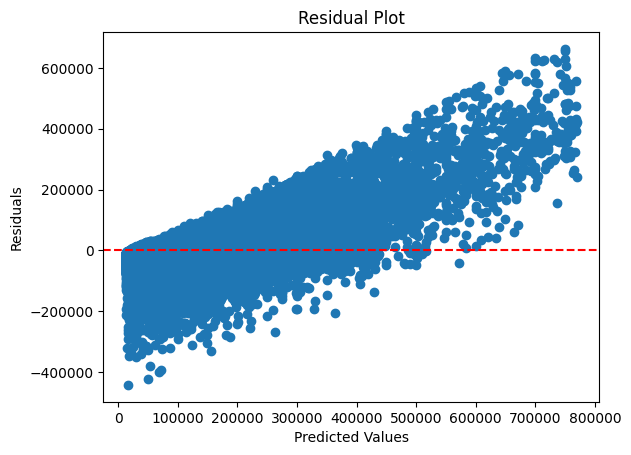

In [35]:
# Plot Residuals
residuals = target_val - model.predict(features_val[selected_features])
plt.scatter(target_val, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

## Обучение моделей на каждый бин на выбранных фичах

In [36]:
# модель на нулевом бине
bin0_model = fit_catboost(
    features_train.loc[bins_train == 0, selected_features], 
    features_val.loc[bins_val == 0, selected_features], 
    target_train.loc[bins_train == 0], 
    target_val.loc[bins_val == 0], 
    selected_features_cat, 
    400
)

WMAE = weighted_mean_absolute_error(
    target_val.loc[bins_val == 0], 
    bin0_model.predict(features_val.loc[bins_val == 0, selected_features]), 
    w_val
)
print(f"WMAE = {WMAE:.2f}")
print(f"Overfit: {bin0_model.evals_result_['validation']['RMSE'][-1] - bin0_model.evals_result_['learn']['RMSE'][-1]}")

# модель на первом бине
bin1_model = fit_catboost(
    features_train.loc[bins_train == 1, selected_features], 
    features_val.loc[bins_val == 1, selected_features], 
    target_train.loc[bins_train == 1], 
    target_val.loc[bins_val == 1], 
    selected_features_cat, 
    400
)

WMAE = weighted_mean_absolute_error(
    target_val.loc[bins_val == 1], 
    bin1_model.predict(features_val.loc[bins_val == 1, selected_features]), 
    w_val
)
print(f"WMAE = {WMAE:.2f}")
print(f"Overfit: {bin1_model.evals_result_['validation']['RMSE'][-1] - bin1_model.evals_result_['learn']['RMSE'][-1]}")

# модель на втором бине
bin2_model = fit_catboost(
    features_train.loc[bins_train == 2, selected_features], 
    features_val.loc[bins_val == 2, selected_features], 
    target_train.loc[bins_train == 2], 
    target_val.loc[bins_val == 2], 
    selected_features_cat, 
    400
)

pred = pd.DataFrame(np.nan, index=target_val.index, columns = ['pred'])
pred.loc[bins_val == 0, 'pred'] = bin0_model.predict(features_val.loc[bins_val == 0, selected_features])
pred.loc[bins_val == 1, 'pred'] = bin1_model.predict(features_val.loc[bins_val == 1, selected_features])
pred.loc[bins_val == 2, 'pred'] = bin2_model.predict(features_val.loc[bins_val == 2, selected_features])

WMAE = weighted_mean_absolute_error(
    target_val, 
    pred['pred'], 
    w_val
)
print(f"WMAE = {WMAE:.2f}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 16074.3560077	test: 16077.6603175	best: 16077.6603175 (0)	total: 98.2ms	remaining: 39.2s
100:	learn: 12483.4274232	test: 12539.8104700	best: 12539.8104700 (100)	total: 8.11s	remaining: 24s
200:	learn: 12215.0054946	test: 12312.7897299	best: 12312.7897299 (200)	total: 16s	remaining: 15.9s
300:	learn: 12036.9897542	test: 12188.1968598	best: 12188.1968598 (300)	total: 24.2s	remaining: 7.97s
399:	learn: 11906.3434886	test: 12116.6954085	best: 12116.6954085 (399)	total: 31.9s	remaining: 0us

bestTest = 12116.69541
bestIteration = 399

WMAE = 4228.65
Overfit: 210.35191988202132


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 26867.2081236	test: 26853.6925061	best: 26853.6925061 (0)	total: 61.9ms	remaining: 24.7s
100:	learn: 23091.7036512	test: 23280.5430584	best: 23280.5430584 (100)	total: 6.42s	remaining: 19s
200:	learn: 22532.8940168	test: 22901.6262967	best: 22901.6262967 (200)	total: 12.4s	remaining: 12.3s
300:	learn: 22097.6567128	test: 22669.6065421	best: 22669.6065421 (300)	total: 18.5s	remaining: 6.1s
399:	learn: 21773.8607330	test: 22559.9534114	best: 22559.9534114 (399)	total: 24.6s	remaining: 0us

bestTest = 22559.95341
bestIteration = 399

WMAE = 6889.00
Overfit: 786.0926783321738


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 128221.2012702	test: 128064.5464238	best: 128064.5464238 (0)	total: 39.4ms	remaining: 15.7s
100:	learn: 107921.5270162	test: 110260.8864780	best: 110260.8864780 (100)	total: 4.5s	remaining: 13.3s
200:	learn: 104010.6190236	test: 108805.0881942	best: 108805.0881942 (200)	total: 8.63s	remaining: 8.55s
300:	learn: 100401.1157526	test: 107958.1810450	best: 107958.1810450 (300)	total: 13s	remaining: 4.26s
399:	learn: 97395.9198982	test: 107662.0097235	best: 107662.0097235 (399)	total: 17.3s	remaining: 0us

bestTest = 107662.0097
bestIteration = 399

WMAE = 19633.89


Text(0.5, 1.0, 'Residual Plot')

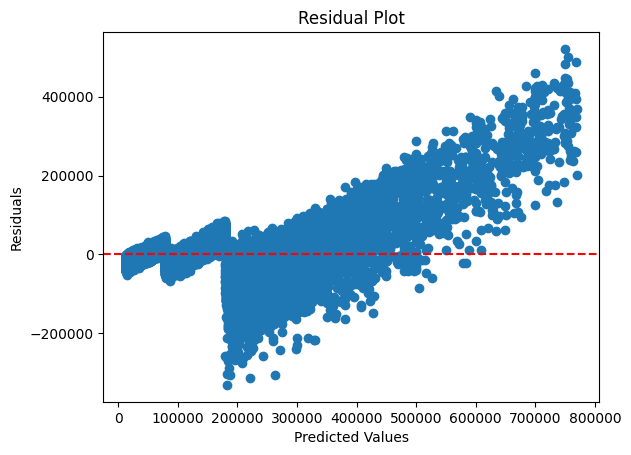

In [38]:
# Plot Residuals
residuals = target_val - pred['pred']
plt.scatter(target_val, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

### Вывод:  
Модели на первух двух бинах имеют низкую ошибку, в отличие от модели на последнем бине. Следовательно модель плохо обучается на клиентах с высокой зарплатой. Возможно стоит выделить 2 группы клиентов: с нормальным и с экстримально высоким доходом и обучить классификатор разделять их.

# Инференс

In [39]:
bin0_pool_train = Pool(
    train_df.loc[train_df['target_bins'] == 0, selected_features],
    train_df.loc[train_df['target_bins'] == 0, 'target'],
    cat_features = selected_features_cat
)

bin0_model = CatBoostRegressor(
    iterations=400,
    learning_rate=0.05,
    loss_function='RMSE'
)

bin0_model.fit(
    bin0_pool_train,
    verbose=100,
    plot=True
)

bin1_pool_train = Pool(
    train_df.loc[train_df['target_bins'] == 1, selected_features],
    train_df.loc[train_df['target_bins'] == 1, 'target'],
    cat_features = selected_features_cat
)

bin1_model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    loss_function='RMSE'
)

bin1_model.fit(
    bin1_pool_train,
    verbose=100,
    plot=True
)

bin2_pool_train = Pool(
    train_df.loc[train_df['target_bins'] == 2, selected_features],
    train_df.loc[train_df['target_bins'] == 2, 'target'],
    cat_features = selected_features_cat
)

bin2_model = CatBoostRegressor(
    iterations=250,
    learning_rate=0.05,
    loss_function='RMSE'
)

bin2_model.fit(
    bin2_pool_train,
    verbose=100,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 16076.5104784	total: 132ms	remaining: 52.7s
100:	learn: 12488.4811429	total: 9.73s	remaining: 28.8s
200:	learn: 12241.1500171	total: 18.9s	remaining: 18.7s
300:	learn: 12068.8276343	total: 28.8s	remaining: 9.46s
399:	learn: 11951.1471570	total: 37.9s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 26877.7153666	total: 61.7ms	remaining: 18.4s
100:	learn: 23133.2964089	total: 6.46s	remaining: 12.7s
200:	learn: 22605.9329458	total: 12.8s	remaining: 6.33s
299:	learn: 22212.7167677	total: 19.7s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 128136.6629031	total: 43ms	remaining: 10.7s
100:	learn: 108147.9961981	total: 4.66s	remaining: 6.88s
200:	learn: 105061.9155354	total: 9s	remaining: 2.19s
249:	learn: 103588.3332902	total: 11.2s	remaining: 0us


# Commit

In [40]:
test_df['predict'] = None
test_df.loc[test_df['target_bins'] == 0, 'predict'] = bin0_model.predict(test_df.loc[test_df['target_bins'] == 0, selected_features])
test_df.loc[test_df['target_bins'] == 1, 'predict'] = bin1_model.predict(test_df.loc[test_df['target_bins'] == 1, selected_features])
test_df.loc[test_df['target_bins'] == 2, 'predict'] = bin2_model.predict(test_df.loc[test_df['target_bins'] == 2, selected_features])
test_df[['client_id','predict']].set_index('client_id').to_csv("data/clf_6_9_reg3.csv", sep=",", decimal=".")